### Overview
Attempts to use LightGBM to predict hourly log returns for crypto
    focused on SANDUSDT

1. Finds log return based on hourly close price
2. Filters df to only have stocks most correlated with SANDUSDT, and BTC
3. Creates train df using engineered features, based on G-Research contest:
- 1. og(close / mean close over timeframe)
- 2. log(close / close x time ago)

- note: #3 and #4 are averaged over all stocks, instead of per stock
- 3. avg. of #1 over all stocks
- 4. avg. of #2 over al stocks

- 5. #1 - #3 (dif. of own stock log(close / mean close), compared to all stock avg.)
- 6. #2 - #4 (dif. of own stock log close / close x time ago, compared to all stock avg.)

4. Uses light GBM to model log returns

### Results
Light GBM is not performing well
1. Tried adjusting params
2. Tried using more columns instead of just other correlated stocks
3. Tried predicting other stocks than SANDUSDT

### Plan
1. Get better data (minute data from July - now)
    - existing functions are not working / too slow
    - create multiprocessed bybit data collection
    - (just have a  process for different time ranges, then aggregate)
2. Write some code to sort of GridSearch through a lot of different settings:
    - Different model params
    - What we are predicting (hourly returns, minute returns, day returns)
        - filter data to only hv hourly as well
    - Columns used (just correlated stocks, or all)
    - Which stock we are predicting (this is the biggest thing to do, instead of just choosing random stocks like SANDUSDT)

In [16]:
"""
Hourly data csv has from June 1 - August 25th
We will use only this data, with train/validation splits

August 25 - now (1 month) will be used for final test
"""

'\nHourly data csv has from June 1 - August 25th\nWe will use only this data, with train/validation splits\n\nAugust 25 - now (1 month) will be used for final test\n'

In [17]:
""" 
Ideas based on https://www.kaggle.com/competitions/g-research-crypto-forecasting/discussion/323703
    problem: too many columns
    reduce features by finding stocks w/ high correlation + market trends
        market: (BTC, Ethereum)
        correlation: try different amounts (start w/ 3 correlated coins)
    
For each shitcoin, we will predict using:
    log(curr price / avg. price during time period)
    log(curr price / price time ago)

    for time values: 1 hr prev, 2h prev, 1d prev
    total: each stock has ~6 cols, so 5*6 = 30 columns?
    30 cols, 2000 rows (seems ok)

    this will give us tabular data

We will start with: SANDUSDT (because it seems to be highly corr. with many stocks from EDA notebook)
    tbf other stocks 'ideo' components could be more correlated with eachother
"""

" \nIdeas based on https://www.kaggle.com/competitions/g-research-crypto-forecasting/discussion/323703\n    problem: too many columns\n    reduce features by finding stocks w/ high correlation + market trends\n        market: (BTC, Ethereum)\n        correlation: try different amounts (start w/ 3 correlated coins)\n    \nFor each shitcoin, we will predict using:\n    log(curr price / avg. price during time period)\n    log(curr price / price time ago)\n\n    for time values: 1 hr prev, 2h prev, 1d prev\n    total: each stock has ~6 cols, so 5*6 = 30 columns?\n    30 cols, 2000 rows (seems ok)\n\n    this will give us tabular data\n\nWe will start with: SANDUSDT (because it seems to be highly corr. with many stocks from EDA notebook)\n    tbf other stocks 'ideo' components could be more correlated with eachother\n"

In [18]:
# Imports
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [19]:
# Create df from SANDUSDT prediction:
# include BTCUSDT, MANAUSDT, GMTUSDT, (stock average)
# now we will start using "close" times instead

stocksData = pd.read_csv('hourlyData.csv')
stocksData = stocksData.set_index('time')
closeData = stocksData.filter(regex='close$', axis=1)

In [20]:
""" 
Feature engineering:
1. log(close / mean close over timeframe)
2. log(close / close x time ago)

note: #3 and #4 are averaged over all stocks, instead of per stock
3. avg. of #1 over all stocks
4. avg. of #2 over al stocks

5. #1 - #3 (dif. of own stock log(close / mean close), compared to all stock avg.)
6. #2 - #4 (dif. of own stock log close / close x time ago, compared to all stock avg.)

Here "all stocks" will only be a very small subset of stocks chosen
    for SANDUSDT, we wil be using: BTCUSDT, MANAUSDT, GMTUSDT

In total, there 4 stocks, 3 different lag periods
    each stock: 4 cols * 3 lags = 12 per stock, *4 = 48 cols
    avg. over alll stock: 2 cols * 3 lags = 6 cols
    total 54 columns
    2000 rows in the dataset
"""

stocksList = ['SANDUSDT', 'BTCUSDT', 'ETHUSDT', 'MANAUSDT']
# stocksList = np.unique([col.split('_')[0] for col in stocksData.columns.tolist() if '_' in col])
print(stocksList)
sandDf = pd.DataFrame()
sandDf.head()

lags = [1, 2, 5, 12, 24]

# Populate features 1 and 2
for stock in stocksList:
    for lag in lags:
        col = stock + '_close'
        sandDf[f'{stock}_log(close/mean_lag{lag})'] = np.log(stocksData[col] / stocksData[col].rolling(lag+1).mean())
        sandDf[f'{stock}_log(close/close_lag{lag})'] = np.log(stocksData[col] / stocksData[col].shift(lag))

# Populate features 3 and 4
for lag in lags:
    filtered1 = [col for col in sandDf.columns if col.endswith(f'_log(close/mean_lag{lag})')]
    sandDf[f'AVG_log(close/mean_lag{lag})'] = sandDf.loc[:,filtered1].mean(axis=1)
    filtered2 = [col for col in sandDf.columns if col.endswith(f'_log(close/close_lag{lag})')]
    sandDf[f'AVG_log(close/close_lag{lag})'] = sandDf.loc[:,filtered2].mean(axis=1)

# Populate features 5 and 6
for stock in stocksList:
    for lag in lags:
        sandDf[f'{stock}-AVG_log(close/mean_lag{lag})'] = sandDf[f'{stock}_log(close/mean_lag{lag})'] - sandDf[f'AVG_log(close/mean_lag{lag})']
        sandDf[f'{stock}-AVG_log(close/close_lag{lag})'] = sandDf[f'{stock}_log(close/mean_lag{lag})'] - sandDf[f'AVG_log(close/close_lag{lag})']

# Add in the targets (which are log returns for the next day, for SANDUSDT only)
sandDf['target'] = np.log(stocksData['SANDUSDT_close'] / stocksData['SANDUSDT_close'].shift(1)).shift(-1)
sandDf = sandDf.dropna(how='any', axis=0)
# sandDf = sandDf.fillna(0)
display(sandDf.head())
stocksData['SANDUSDT_close']

['SANDUSDT', 'BTCUSDT', 'ETHUSDT', 'MANAUSDT']


,SANDUSDT_log(close/mean_lag1),SANDUSDT_log(close/close_lag1),SANDUSDT_log(close/mean_lag2),SANDUSDT_log(close/close_lag2),SANDUSDT_log(close/mean_lag5),SANDUSDT_log(close/close_lag5),SANDUSDT_log(close/mean_lag12),SANDUSDT_log(close/close_lag12),SANDUSDT_log(close/mean_lag24),SANDUSDT_log(close/close_lag24),...,MANAUSDT-AVG_log(close/close_lag1),MANAUSDT-AVG_log(close/mean_lag2),MANAUSDT-AVG_log(close/close_lag2),MANAUSDT-AVG_log(close/mean_lag5),MANAUSDT-AVG_log(close/close_lag5),MANAUSDT-AVG_log(close/mean_lag12),MANAUSDT-AVG_log(close/close_lag12),MANAUSDT-AVG_log(close/mean_lag24),MANAUSDT-AVG_log(close/close_lag24),target
time,,,,,,,,,,,,,,,,,,,,,
2024-06-02 01:00:00,-0.002005,-0.004006,-1.930933e-03,-0.001783,0.002792,0.013923,0.015177,0.032180,0.023878,0.033794,...,0.002334,0.000066,0.000299,0.001093,-0.001512,0.005311,-0.002251,0.007922,0.002781,0.002005
2024-06-02 02:00:00,0.001002,0.002005,-1.110223e-16,-0.002001,0.002154,0.005804,0.014555,0.035799,0.024440,0.035107,...,-0.000375,0.001946,0.002832,0.001984,0.001061,0.006360,-0.003779,0.009399,0.003232,-0.007596
2024-06-02 03:00:00,-0.003805,-0.007596,-4.400857e-03,-0.005591,-0.005145,-0.000673,0.004807,0.024979,0.015741,0.028895,...,0.000970,-0.002502,-0.002057,-0.002546,-0.004364,0.001104,-0.008665,0.004388,-0.005597,0.004252
2024-06-02 04:00:00,0.002124,0.004252,2.977963e-04,-0.003344,-0.001488,-0.003122,0.006826,0.022128,0.018663,0.030611,...,-0.001011,-0.001883,0.002042,-0.002533,-0.000944,0.000121,-0.007069,0.003513,-0.003601,-0.004476
2024-06-02 05:00:00,-0.002241,-0.004476,-1.568979e-03,-0.000224,-0.004700,-0.009822,0.001001,0.011279,0.013141,0.028209,...,0.001267,-0.001292,-0.000919,-0.003114,0.000847,-0.001864,-0.006087,0.001454,-0.007229,-0.005173


time
2024-06-01 01:00:00    0.4335
2024-06-01 02:00:00    0.4338
2024-06-01 03:00:00    0.4332
2024-06-01 04:00:00    0.4343
2024-06-01 05:00:00    0.4334
                        ...  
2024-08-24 20:00:00    0.2985
2024-08-24 21:00:00    0.2960
2024-08-24 22:00:00    0.2991
2024-08-24 23:00:00    0.2971
2024-08-25 00:00:00    0.2981
Name: SANDUSDT_close, Length: 2040, dtype: float64

# Modelling

In [21]:
""" 
Find baseline metrics
    prediction of 0 for log returns
    prediction of mean(log returns)
"""

from sklearn.metrics import mean_squared_error, mean_absolute_error

y = sandDf['target']

# Visualize log returns rq
# plt.hist(y, bins=40)
# plt.show()
# plt.violinplot(y)
# plt.show()
# print(y.describe())

# Find error of predicting 0, and predicting mean
print("Predicting 0:")
print(f'MSE: {mean_squared_error(y, np.zeros(len(y))):.7f}')
print(f'MAE: {mean_absolute_error(y, np.zeros(len(y))):.7f}')

print("Predicting Log Returns Mean:")
print(f'MSE: {mean_squared_error(y, np.mean(y)*np.ones(len(y))):.7f}')
print(f'MAE: {mean_absolute_error(y, np.mean(y)*np.ones(len(y))):.7f}')

Predicting 0:
MSE: 0.0000788
MAE: 0.0057077
Predicting Log Returns Mean:
MSE: 0.0000788
MAE: 0.0057062


In [22]:
# define the evaluation metric (from 3rd place G Research solution)
def correlation(a, train_data):
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

In [23]:
""" 
Train light gbm model
"""

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

params = {
    # 'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse', 
    'learning_rate': 0.01,
    'num_leaves': 15,
    'zero_as_missing': True
}

X, y = sandDf.drop(columns=['target']), sandDf['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Train model
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, validation_data],
    feval=correlation
)

# Predict and calculate RMSE
y_train_pred = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("Train data:")
print(f'MSE: {mse_train:.7f}')
print(f'MAE: {mae_train:.7f}')

print("Test data:")
print(f'MSE: {mse:.7f}')
print(f'MAE: {mae:.7f}')

X_train.info()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 1612, number of used features: 90
[LightGBM] [Info] Start training from score -0.000215
Train data:
MSE: 0.0000224
MAE: 0.0033442
Test data:
MSE: 0.0001081
MAE: 0.0063118
<class 'pandas.core.frame.DataFrame'>
Index: 1612 entries, 2024-06-12 22:00:00 to 2024-07-18 23:00:00
Data columns (total 90 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SANDUSDT_log(close/mean_lag1)        1612 non-null   float64
 1   SANDUSDT_log(close/close_lag1)       1612 non-null   float64
 2   SANDUSDT_log(close/mean_lag2)        1612 non-null   float64
 3   SANDUSDT_log(close/close_lag2)       1612 non-null   float64
 4   SANDUSDT_log(close/mean_lag5)        1

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

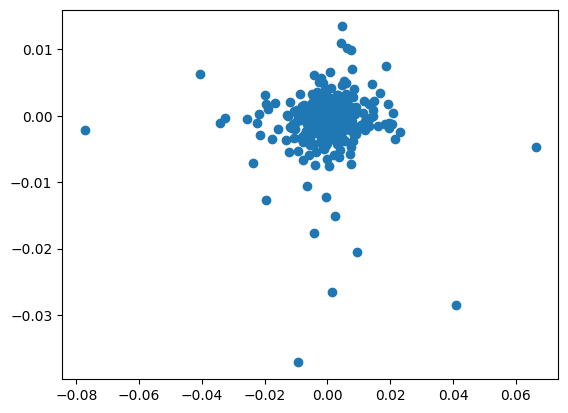

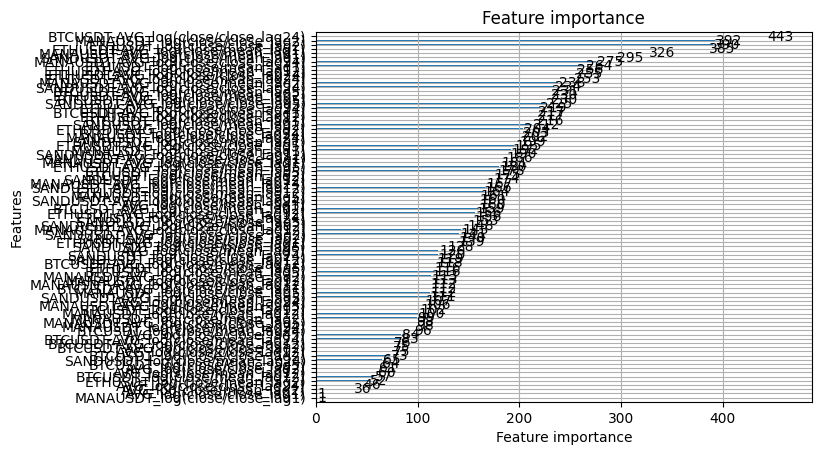

In [24]:
""" 
Visualize predictions
"""
plt.scatter(y_test, y_pred)
lgb.plot_importance(model)